In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from tensorflow.keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2d
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
from colorizers import *

In [11]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from tensorflow.keras.utils import img_to_array

In [12]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
path = '../color_dataset'
files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]
files = files[:3000]
for i in tqdm(files):    
        img = cv2.imread(os.path.join(path, i), 1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '../gray_dataset'
files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]
files = files[:3000]
for i in tqdm(files):
        img = cv2.imread(os.path.join(path, i), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../color_dataset'

In [13]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(64)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(64)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:])).batch(8)

NameError: name 'gray_img' is not defined

In [14]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

StopIteration: 

In [15]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

NameError: name 'example_color' is not defined

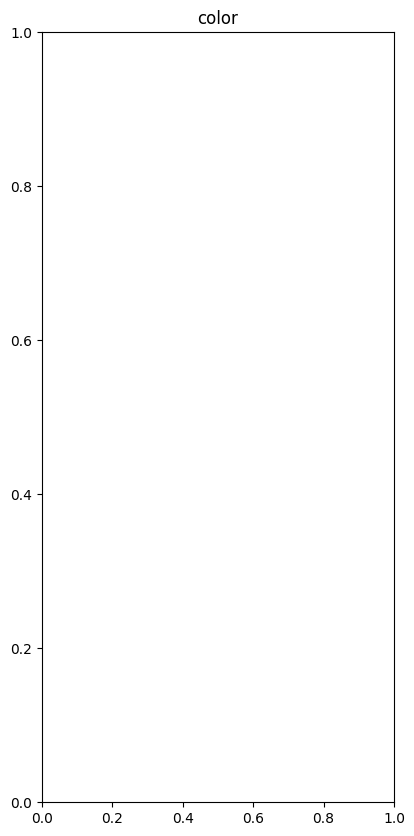

In [16]:
plot_images(4)

In [17]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result  

In [18]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [20]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      6,144 │ concatenate[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_2[0][… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_3[0]… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [21]:
genLoss=[]
discLoss=[]

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss

In [23]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [24]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch: ", epoch+1)
    # Train
    for n, (input_image, target) in train_ds.enumerate():
      train_step(input_image, target, epoch)
    print()
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

In [25]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)

NameError: name 'gray_dataset' is not defined

In [26]:
hist=fit(tf.data.Dataset.zip((gray_dataset, color_dataset)), epochs = 10)

NameError: name 'gray_dataset' is not defined

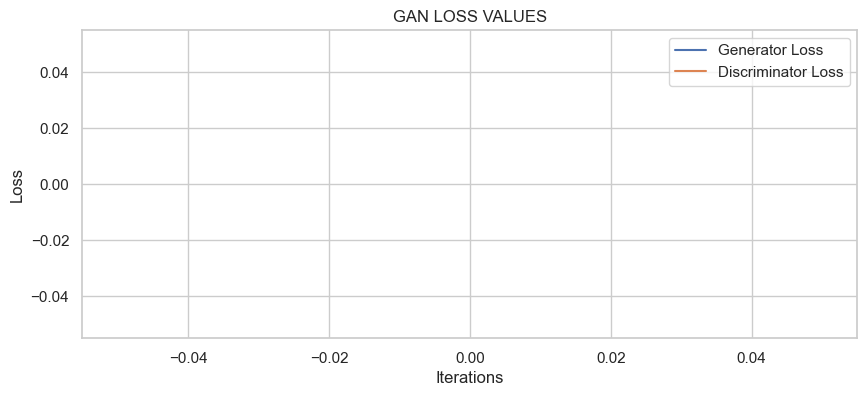

In [27]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,4))
plt.plot(genLoss, label="Generator Loss")
plt.plot(discLoss, label="Discriminator Loss")
plt.title("GAN LOSS VALUES")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(11):
  generate_images(generator, example_input, example_target)

NameError: name 'gray_dataset' is not defined

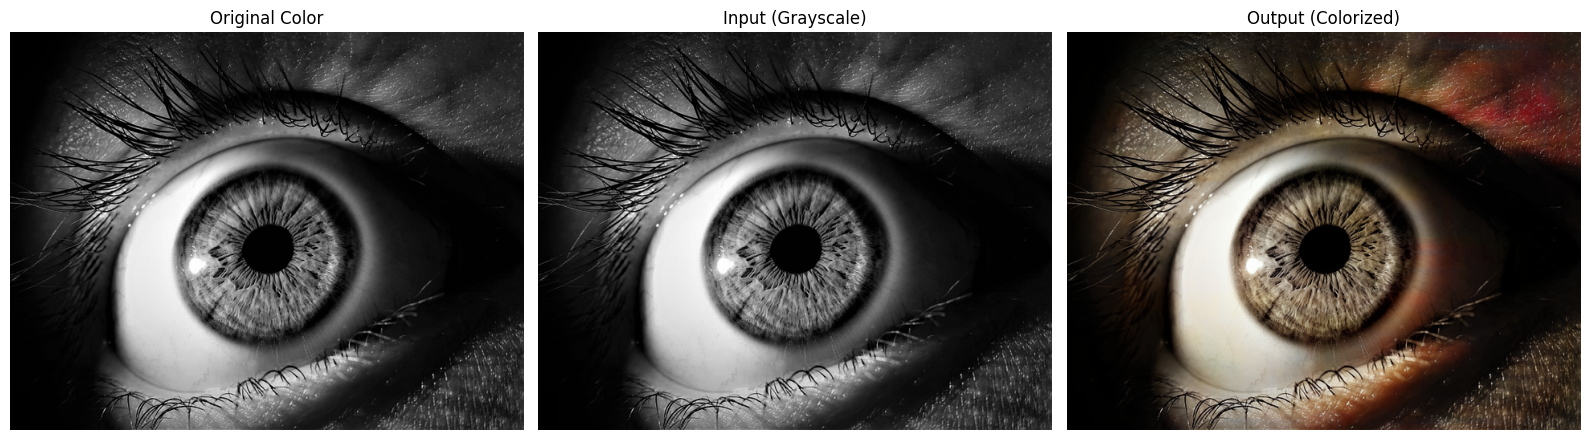

Processing 5.jpg:
  SSIM: 0.9605
  MSE: 0.0025
  PSNR: 26.0133 dB



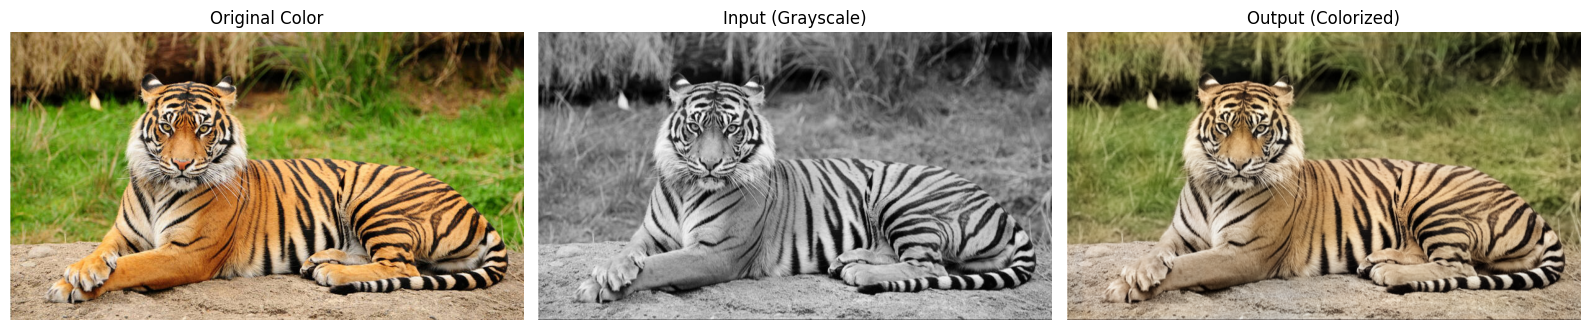

Processing tiger.jpg:
  SSIM: 0.8671
  MSE: 0.0062
  PSNR: 22.0490 dB



In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import numpy as np
from colorizers import *
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns

def colorize_images(sample_folder, color_folder):
    # Load the colorizer model
    colorizer = siggraph17(pretrained=True).eval()

    # Get a list of image file paths in the sample folder
    image_files = [f for f in os.listdir(sample_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files:
        img_path = os.path.join(sample_folder, img_file)
        color_img_path = os.path.join(color_folder, img_file)
        
        # Check if both grayscale and color images exist
        if not os.path.exists(img_path):
            print(f"Grayscale image not found: {img_path}")
            continue
        if not os.path.exists(color_img_path):
            print(f"Color image not found: {color_img_path}")
            continue
        
        try:
            # Open grayscale image with PIL and convert to RGB
            pil_img = Image.open(img_path).convert('RGB')
            
            # Open original color image with PIL
            pil_color_img = Image.open(color_img_path)
            
            # Convert to RGB if it's not already
            if pil_color_img.mode != 'RGB':
                pil_color_img = pil_color_img.convert('RGB')
            
            # Convert to numpy array
            img = np.array(pil_img)
            color_img = np.array(pil_color_img)

            # Preprocess image with larger size
            (tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(512, 512))
            img_bw = postprocess_tens(tens_l_orig, torch.cat((0 * tens_l_orig, 0 * tens_l_orig), dim=1))
            out_img = postprocess_tens(tens_l_orig, colorizer(tens_l_rs).cpu())

            # Ensure all images are in the range [0, 1]
            original = color_img.astype(np.float32) / 255.0
            colorized = out_img.astype(np.float32) / 255.0

            # Ensure both images have the same shape
            min_shape = tuple(min(s1, s2) for s1, s2 in zip(original.shape, colorized.shape))
            original = original[:min_shape[0], :min_shape[1], :min_shape[2]]
            colorized = colorized[:min_shape[0], :min_shape[1], :min_shape[2]]

            # Calculate SSIM (Structural Similarity Index)
            win_size = min(7, min(original.shape[0], original.shape[1]) - 1)
            if win_size % 2 == 0:
                win_size -= 1  # Ensure odd window size
            ssim_value = ssim(original, out_img, win_size=win_size, channel_axis=2, data_range=1.0)

            # Calculate MSE (Mean Squared Error)
            mse_value = mean_squared_error(original, out_img)

            # Calculate PSNR (Peak Signal-to-Noise Ratio)
            max_pixel = 1.0
            psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse_value))
            

            # Display images and metrics
            plt.figure(figsize=(16, 6))  # Adjust the figsize as needed
            plt.subplot(1, 3, 1)
            plt.imshow(color_img)
            plt.title('Original Color')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(img, cmap='gray')
            plt.title('Input (Grayscale)')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(out_img)
            plt.title('Output (Colorized)')
            plt.axis('off')

            plt.tight_layout()  # Ensures all subplots fit nicely in the figure
            plt.show()


            # plt.subplot(2, 2, 4)
            # plt.imshow(np.abs(original - colorized))
            # plt.title('Difference')
            # plt.axis('off')

            print(f"Processing {img_file}:")
            print(f"  SSIM: {ssim_value:.4f}")
            print(f"  MSE: {mse_value:.4f}")
            print(f"  PSNR: {psnr_value:.4f} dB")
            print()


        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")

# Usage
sample_folder_path = "./sample"
color_folder_path = "./color_images"
colorize_images(sample_folder_path, color_folder_path)